In [631]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
import pandas as pd
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy import stats


%matplotlib inline
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

from sklearn.preprocessing import StandardScaler
import random

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (18, 4)

In [632]:
inputdata1 = "../output_mo/combined_mo_data/" 
inputdata2 = "../output_qt/combined_qt_data/" #just to get gdp_total
outputdata1 = "../output_mo/regressiondata_mo/"

In [633]:
def x_data():
    x_data = pd.read_csv(inputdata1 + "a0_combinedMonthly_extended_ARIMA.csv", index_col=0)
    first_date = x_data.index[0]

    x_data.index = pd.date_range(first_date, x_data.index[-1], freq='MS').date
    return x_data

### Change quarterly data to monthly using smoothing

In [634]:
def y_data(seasonal=True):
    if seasonal:
        y_data = pd.read_csv(inputdata2 + "a0_combinedQuarterly_extended_ARIMA.csv", index_col=0)['gdp_total_deseasonalized'].to_frame()
    else:
        y_data = pd.read_csv(inputdata2 + "a0_combinedQuarterly_extended_ARIMA.csv", index_col=0)['gdp_total'].to_frame()

    first_date = y_data.index[0]
    y_data.index = pd.PeriodIndex(y_data.index, freq='Q')
    y_data['Date'] = y_data.index.to_timestamp()

    # convert to period
    y_data['Date'] = pd.to_datetime(y_data['Date']).dt.to_period('M')
    # set Date as index and resample
    y_data = y_data.set_index('Date').resample('M').interpolate()

    y_data.index = y_data.index.strftime('%Y-%m-%d')
    y_data.index = pd.date_range(first_date, y_data.index[-1], freq='MS').date
    return y_data

### Combine Y and X data

In [635]:
regressionData = y_data(seasonal=True).merge(x_data(), left_index=True, right_index=True, how='outer')
regressionData.to_csv(outputdata1 + "regressiondata_mo.csv")
df1 = regressionData.iloc[0:355,:].copy()

df1.head()

,gdp_total_deseasonalized,^AEX,ASML.AS,AIR,ING,WKL.AS,STLA,AD.AS,PHG,^FVX,...,Italy_unemply_F,Italy_unemply_M,Spain_unemply_F,Spain_unemply_M,Belgium_unemply_F,Belgium_unemply_M,Japan_unemply_F,Japan_unemply_M,United States_unemply_F,United States_unemply_M
1995-01-01,NaN,187.171368,NaN,6.981737,3.254188,NaN,NaN,NaN,3.909096,7.741667,...,14.6,8.7,28.7,17.2,12.7,7.8,3.1,3.0,5.8,6.6
1995-02-01,NaN,186.834868,NaN,7.055270,3.319502,NaN,NaN,NaN,4.089017,7.357895,...,16.3,9.0,28.7,17.1,12.6,7.7,3.1,3.0,5.5,6.2
1995-03-01,NaN,179.719088,NaN,6.749855,3.387886,6.580569,NaN,NaN,4.233587,7.037478,...,16.4,9.2,28.5,16.7,12.4,7.5,3.5,3.3,5.4,5.9
1995-04-01,NaN,184.062915,NaN,6.915176,3.580347,6.756925,NaN,NaN,4.432652,6.845158,...,15.4,9.3,27.9,16.5,12.1,7.3,3.3,3.1,5.5,5.7
1995-05-01,NaN,193.378887,NaN,7.321506,3.789411,7.071823,NaN,NaN,4.931614,6.406045,...,15.3,8.1,27.7,16.3,12.0,7.1,3.2,3.0,5.3,5.6


In [636]:
#############################
# change name if seasonally adjusted for code consistency
#############################
if(any([col for col in df1.columns if 'gdp_total_deseasonalized' in col])):
    df1.insert(0, 'gdp_total', df1.pop('gdp_total_deseasonalized'))

In [637]:
# subset of the data
df1 = df1[['gdp_total', 
          '^AEX', 
          'EconomischeSituatieKomende12Maanden_5',
          'ProducerConfidence_1', 
          'Consumentenvertrouwen_1',
          'Crude oil, Brent', 
          'Coffee, Arabica', 
          'Gold', 
          'M3_1', 
          'M3_2',
          'CCICP_NLD_CLI', 
          'Netherlands_unemply_F',
          'Netherlands_unemply_M', 
          'Bankruptcies', 
          'FinancieleSituatieKomende12Maanden_7', 
          'Natural gas, Europe', 
          'CCICP_DEU', 
          'United States_unemply_M', 
          'Coconut oil'
        ]]


In [638]:
df1.describe()

,gdp_total,^AEX,EconomischeSituatieKomende12Maanden_5,ProducerConfidence_1,Consumentenvertrouwen_1,"Crude oil, Brent","Coffee, Arabica",Gold,M3_1,M3_2,CCICP_NLD_CLI,Netherlands_unemply_F,Netherlands_unemply_M,Bankruptcies,FinancieleSituatieKomende12Maanden_7,"Natural gas, Europe",CCICP_DEU,United States_unemply_M,Coconut oil
count,343.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,3.550000e+02,3.550000e+02,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000
mean,189495.553936,464.578606,1.118310,-1.264225,-4.391549,58.300087,3.260175,979.726174,6.759086e+05,6.347434e+05,100.204791,6.602254,4.915493,561.073239,5.692958,8.029694,99.892557,5.726197,952.114905
std,25228.839226,156.286999,30.216312,5.992763,22.547412,32.217385,1.220763,590.539832,2.784914e+05,2.563931e+05,1.279505,1.963263,1.537226,238.613024,13.339074,7.804640,1.338809,2.020744,425.469535
min,135716.000000,179.719088,-69.000000,-31.500000,-59.000000,9.800000,1.196400,256.080000,2.250190e+05,2.084460e+05,96.259940,3.400000,2.000000,132.000000,-31.000000,1.575165,96.262140,3.200000,285.000000
25%,169885.333333,338.632505,-22.000000,-3.900000,-25.000000,27.547205,2.502686,383.100000,4.222460e+05,4.078070e+05,99.342685,4.900000,3.650000,364.000000,-1.000000,3.615186,98.709645,4.300000,649.500000
50%,190776.000000,451.290454,6.000000,-0.800000,-3.000000,57.579048,3.108073,1043.159000,7.331960e+05,6.940590e+05,100.375100,6.600000,4.800000,513.000000,5.000000,6.345738,100.004800,5.100000,827.500000
75%,207112.500000,553.519480,27.000000,3.100000,14.000000,80.620000,3.915850,1382.616500,8.867715e+05,8.280480e+05,101.185500,7.900000,5.950000,757.500000,13.000000,9.690000,101.033250,6.450000,1210.070000
max,237780.000000,922.693997,49.000000,10.400000,36.000000,133.873043,6.616506,2398.200000,1.184061e+06,1.099461e+06,102.336700,12.000000,8.800000,1185.000000,35.000000,70.043640,102.031300,13.300000,2256.000000


### Add 'sure' data and random data

In [639]:
# create a sure-fire predictor
df1['gdp_total_dirty_0'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']
df1['gdp_total_dirty_1'] = [random.random() * 20000 for _ in range(0, len(df1))] + df1['gdp_total']

# randos
df1['random_0'] = [random.random() for _ in range(0, len(df1))] 
df1['random_1'] = [random.random() for _ in range(0, len(df1))] 

In [640]:
df1

,gdp_total,^AEX,EconomischeSituatieKomende12Maanden_5,ProducerConfidence_1,Consumentenvertrouwen_1,"Crude oil, Brent","Coffee, Arabica",Gold,M3_1,M3_2,...,Bankruptcies,FinancieleSituatieKomende12Maanden_7,"Natural gas, Europe",CCICP_DEU,United States_unemply_M,Coconut oil,gdp_total_dirty_0,gdp_total_dirty_1,random_0,random_1
1995-01-01,NaN,187.171368,15.0,3.5,2.0,16.630,3.805600,378.55,225019.0,208446.0,...,514.0,6.0,2.660000,99.79736,6.6,622.00,NaN,NaN,0.690455,0.294430
1995-02-01,NaN,186.834868,23.0,3.5,8.0,17.080,3.743100,376.64,227807.0,211192.0,...,453.0,10.0,2.660000,99.73475,6.2,636.00,NaN,NaN,0.380118,0.447341
1995-03-01,NaN,179.719088,26.0,3.1,12.0,17.010,3.955800,382.12,225759.0,209071.0,...,565.0,12.0,2.650000,99.84422,5.9,632.00,NaN,NaN,0.478923,0.392923
1995-04-01,NaN,184.062915,20.0,3.5,11.0,18.670,3.844900,391.03,225604.0,208766.0,...,478.0,12.0,2.710000,99.95764,5.7,619.00,NaN,NaN,0.614455,0.448926
1995-05-01,NaN,193.378887,21.0,3.1,12.0,18.380,3.770100,385.22,230172.0,213286.0,...,443.0,11.0,2.710000,100.02810,5.6,616.00,NaN,NaN,0.415855,0.693025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,234992.666667,863.843002,-27.0,-4.8,-22.0,85.447,4.605010,2158.01,1156784.0,1071931.0,...,345.0,4.0,8.553726,99.10613,4.1,1287.86,241845.721283,248036.984293,0.211577,0.671344
2024-04-01,235834.000000,877.564285,-29.0,-3.6,-21.0,90.054,5.274333,2331.45,1141262.0,1056337.0,...,427.0,5.0,9.085119,99.45507,3.7,1425.23,255333.878676,236655.382642,0.883811,0.102960
2024-05-01,236482.666667,906.555914,-33.0,-2.8,-22.0,81.995,5.083192,2351.13,1158783.0,1073759.0,...,343.0,4.0,10.123066,99.67835,4.0,1401.74,254756.266039,242900.350280,0.252957,0.903186
2024-06-01,237131.333333,922.693997,-30.0,-2.4,-23.0,82.555,5.476056,2326.44,1152080.0,1066696.0,...,377.0,2.0,10.868978,99.79649,4.1,1397.89,244693.738900,256516.847727,0.304189,0.213325


(355, 23)


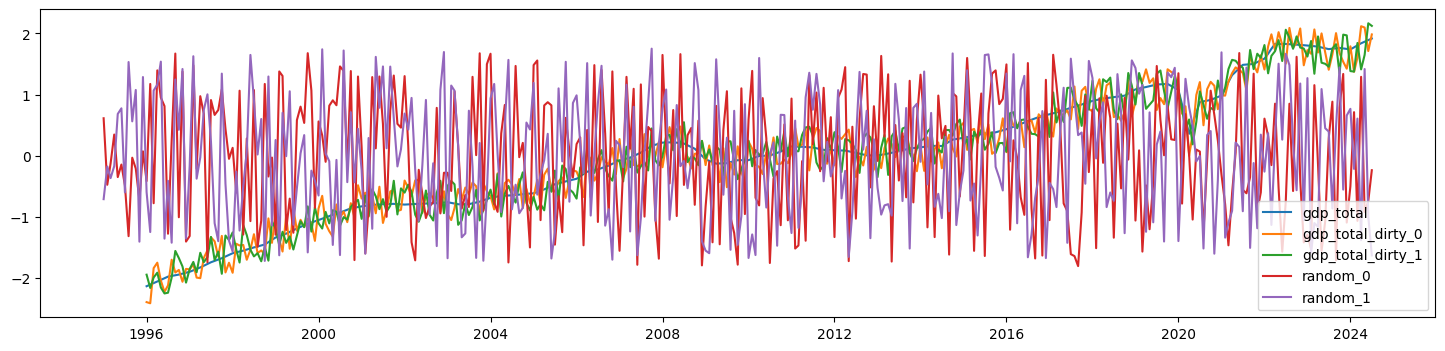

In [641]:
scaler = StandardScaler()
df1_scaled = scaler.fit_transform(df1)

scaled_features_df = pd.DataFrame(df1_scaled, index=df1.index, columns=df1.columns)
scaled_features_df[['gdp_total','gdp_total_dirty_0','gdp_total_dirty_1', 'random_0', 'random_1']].plot()
scaled_features_df.head()

print(scaled_features_df.shape)

In [642]:
#############################
# Dataframe of column names for storing tests
#############################

STORE_FOR_TESTS = pd.DataFrame(columns=scaled_features_df.columns).T

STORE_FOR_TESTS['Qt_Seasonality'] = np.nan
STORE_FOR_TESTS['Semi_Seasonality'] = np.nan
STORE_FOR_TESTS['Level_Stationary'] = np.nan
STORE_FOR_TESTS['Difference_Stationary'] = np.nan
STORE_FOR_TESTS['Difference_Data'] = 'False'

In [643]:
def seasonality_test(data):
    kw_test1 = data.iloc[0:300,:]
    kw_test1['Months'] = [1,2,3,4,5,6,7,8,9,10,11,12] * int(len(kw_test1)/12)
    kw_test1['Semi'] = [1,2,3,4,5,6] * int(len(kw_test1)/6)
    kw_test1.dropna(inplace=True)
    
    return kw_test1

kw1 = seasonality_test(scaled_features_df)

### Deseasonalize if needed (Kruskal-Wallis test)

In [644]:
def Kruskal_Wallis_Monthly(data, STORE_FOR_TESTS): # Monthly seasonality
    
    for col in data.columns:
        # no need to test these
        if (col == 'Months' or col == 'Semi'):
            continue
        res = []
        for i in data['Months'].unique():
            res.append(data[data['Months'] == i][col].values)
        results = stats.kruskal(*res)
        if (results[1] > 0.50):  #p-value
            STORE_FOR_TESTS.loc[col,'Monthly_Seasonality'] = 'No_Monthly_Seasonality'
        else:
            STORE_FOR_TESTS.loc[col, 'Monthly_Seasonality'] = 'Monthly_Seasonality'

    return STORE_FOR_TESTS

STORE_FOR_TESTS = Kruskal_Wallis_Monthly(kw1, STORE_FOR_TESTS)
STORE_FOR_TESTS

,Qt_Seasonality,Semi_Seasonality,Level_Stationary,Difference_Stationary,Difference_Data,Monthly_Seasonality
gdp_total,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
^AEX,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
EconomischeSituatieKomende12Maanden_5,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
ProducerConfidence_1,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
Consumentenvertrouwen_1,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
"Crude oil, Brent",NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
"Coffee, Arabica",NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
Gold,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
M3_1,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality
M3_2,NaN,NaN,NaN,NaN,False,No_Monthly_Seasonality


In [645]:
def Kruskal_Wallis_Semi(data, STORE_FOR_TESTS): # Monthly seasonality
    
    for col in data.columns:
        # no need to test these
        if (col == 'Months' or col == 'Semi'):
            continue
        res = []
        for i in data['Semi'].unique():
            res.append(data[data['Semi'] == i][col].values)
        results = stats.kruskal(*res)
        if (results[1] > 0.50):  #p-value
            STORE_FOR_TESTS.loc[col,'Semi_Seasonality'] = 'No_Semi_Seasonality'
        else:
            STORE_FOR_TESTS.loc[col, 'Semi_Seasonality'] = 'Semi_Seasonality'

    return STORE_FOR_TESTS

STORE_FOR_TESTS = Kruskal_Wallis_Semi(kw1, STORE_FOR_TESTS)
STORE_FOR_TESTS

,Qt_Seasonality,Semi_Seasonality,Level_Stationary,Difference_Stationary,Difference_Data,Monthly_Seasonality
gdp_total,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
^AEX,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
EconomischeSituatieKomende12Maanden_5,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
ProducerConfidence_1,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
Consumentenvertrouwen_1,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
"Crude oil, Brent",NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
"Coffee, Arabica",NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
Gold,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
M3_1,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality
M3_2,NaN,No_Semi_Seasonality,NaN,NaN,False,No_Monthly_Seasonality


<Axes: >

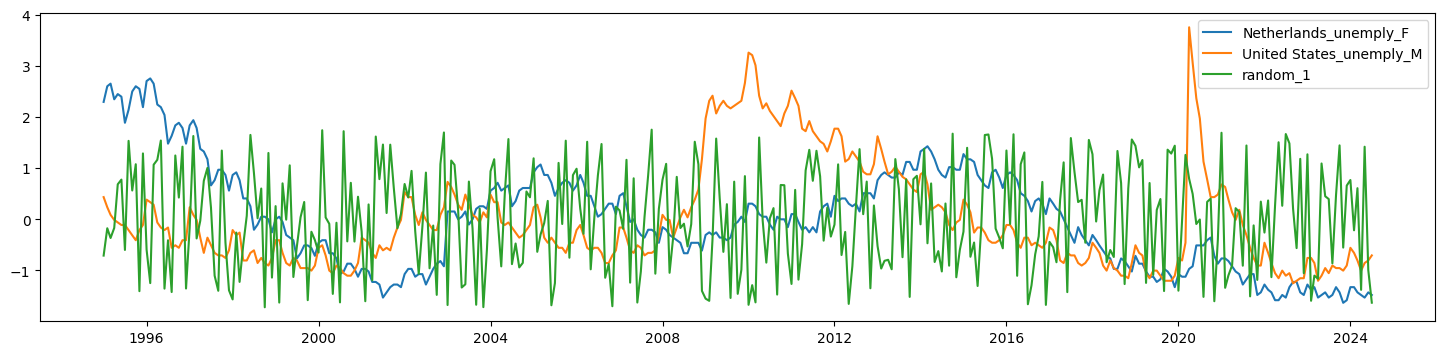

In [646]:
scaled_features_df[['Netherlands_unemply_F', 'United States_unemply_M', 'random_1']].plot()

In [647]:
scaled_features_df.dropna(inplace=True)

In [648]:
# Select feature if contains seasonality (so "No_ not present in name", then deseasonalize)


deseasonalizeThese = STORE_FOR_TESTS[~STORE_FOR_TESTS['Semi_Seasonality'].str.contains("No_")].index

for i in deseasonalizeThese:

    smdt = scaled_features_df[i]

    if any(smdt < 0):
        smdata = sm.tsa.seasonal_decompose(scaled_features_df[i], model='additive', period=12)
        scaled_features_df.loc[:, i] = smdata.trend
    else:
        smdata = sm.tsa.seasonal_decompose(scaled_features_df[i], model='multiplicative', period=12)
        scaled_features_df.loc[:, i] = smdata.trend

scaled_features_df

,gdp_total,^AEX,EconomischeSituatieKomende12Maanden_5,ProducerConfidence_1,Consumentenvertrouwen_1,"Crude oil, Brent","Coffee, Arabica",Gold,M3_1,M3_2,...,Bankruptcies,FinancieleSituatieKomende12Maanden_7,"Natural gas, Europe",CCICP_DEU,United States_unemply_M,Coconut oil,gdp_total_dirty_0,gdp_total_dirty_1,random_0,random_1
1996-01-01,-2.134784,-1.513526,0.493200,-0.022688,0.594767,-1.254511,-0.673295,-0.984007,-1.579886,-1.619645,...,-0.281493,0.398418,-0.677436,-1.042324,NaN,-0.567503,-2.394721,-1.945914,NaN,-0.594828
1996-02-01,-2.108942,-1.505365,0.062362,-0.256633,0.372699,-1.253578,-0.430235,-0.975002,-1.574780,-1.614180,...,-0.508120,0.398418,-0.674870,-1.207390,NaN,-0.503954,-2.413728,-2.163142,NaN,-1.248289
1996-03-01,-2.083101,-1.459823,-0.434759,-0.156371,0.106217,-1.190791,-0.488970,-0.989501,-1.569491,-1.609208,...,-0.352839,0.248271,-0.687701,-1.205056,NaN,-0.539259,-1.838165,-1.991381,NaN,1.066936
1996-04-01,-2.057259,-1.390792,-0.699891,-0.156371,0.017390,-1.159086,-0.440900,-0.995199,-1.561260,-1.600370,...,-0.520711,0.398418,-0.632528,-1.202550,NaN,-0.461588,-1.749767,-1.912867,NaN,1.162332
1996-05-01,-2.030770,-1.349116,-0.335335,-0.156371,0.195044,-1.217833,-0.336555,-0.996759,-1.545071,-1.583653,...,-0.331855,0.548566,-0.669738,-1.228558,NaN,-0.409808,-2.041581,-2.155121,NaN,1.539281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,1.806012,2.558293,-0.931881,-0.590840,-0.782054,0.843806,1.103189,1.998082,1.729153,1.707553,...,-0.906816,-0.127096,0.067238,-0.588237,NaN,0.790230,1.603010,1.844583,NaN,0.607387
2024-04-01,1.839409,2.646212,-0.998164,-0.390316,-0.737641,0.987005,1.652245,2.292194,1.673338,1.646646,...,-0.562679,-0.052023,0.135421,-0.327234,NaN,1.113553,2.118841,1.412291,NaN,-1.380013
2024-05-01,1.865157,2.831977,-1.130729,-0.256633,-0.782054,0.736508,1.495450,2.325566,1.736341,1.714692,...,-0.915210,-0.127096,0.268600,-0.160224,NaN,1.058265,2.096752,1.649485,NaN,1.418043
2024-06-01,1.890906,2.935382,-1.031305,-0.189792,-0.826468,0.753914,1.817722,2.283698,1.712238,1.687106,...,-0.772519,-0.277243,0.364308,-0.071856,NaN,1.049204,1.711927,2.166662,NaN,-0.994113


[ 7 18 19]
['M3_1', 'gdp_total_dirty_0', 'gdp_total_dirty_1']


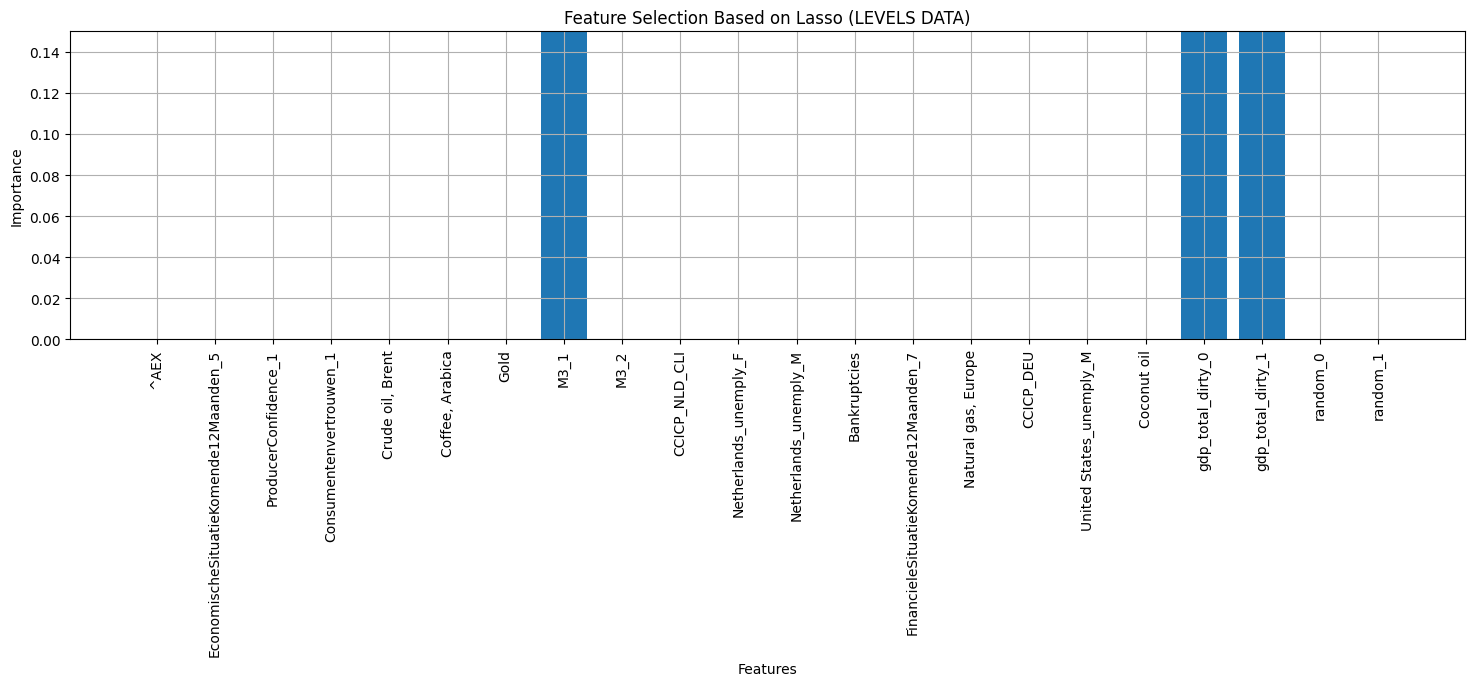

(343, 23)


In [649]:
def lassoreg(data, alpha=0.0001, title='Feature Selection Based on Lasso'):

    myalpha = alpha
    data1 = data.copy()
    data1 = data1.dropna()

    Xcolnames =  data1.iloc[:, 1:]

    Y = data1.iloc[:, 0].values
    X = data1.iloc[:, 1:].values

    ### assertions
    # does X contain gdptotal, it should not
    assert X.shape[1] == data.shape[1] - 1

    # does X contain gdptotal, it should not
    val = 'gdp_total'
    lst = Xcolnames.columns
    assert val not in lst

    # regression
    lasso = Lasso(alpha = myalpha, fit_intercept=False, max_iter=10000)
    
    lasso.fit(X,Y)

    selected_features_lasso = np.flatnonzero(lasso.coef_)
    print(selected_features_lasso)

    best_variables = [Xcolnames.columns[i] for i in selected_features_lasso]
    print(best_variables)


    # calling the model with the best parameter
    lasso1 = Lasso(alpha=myalpha)
    lasso1.fit(X, Y)

    # Using np.abs() to make coefficients positive.  
    lasso1_coef = np.abs(lasso1.coef_)

    # plotting the Column Names and Importance of Columns. 
    plt.bar(lst, lasso1_coef)
    plt.xticks(rotation=90)
    plt.grid()
    plt.title(title)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.ylim(0, 0.15)
    plt.show()

    return best_variables

lassoreg(scaled_features_df, alpha=0.1, title='Feature Selection Based on Lasso (LEVELS DATA)')

print(scaled_features_df.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
['^AEX', 'EconomischeSituatieKomende12Maanden_5', 'ProducerConfidence_1', 'Consumentenvertrouwen_1', 'Crude oil, Brent', 'Coffee, Arabica', 'Gold', 'M3_1', 'M3_2', 'CCICP_NLD_CLI', 'Netherlands_unemply_F', 'Netherlands_unemply_M', 'Bankruptcies', 'FinancieleSituatieKomende12Maanden_7', 'Natural gas, Europe', 'CCICP_DEU', 'United States_unemply_M', 'Coconut oil', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'random_1']


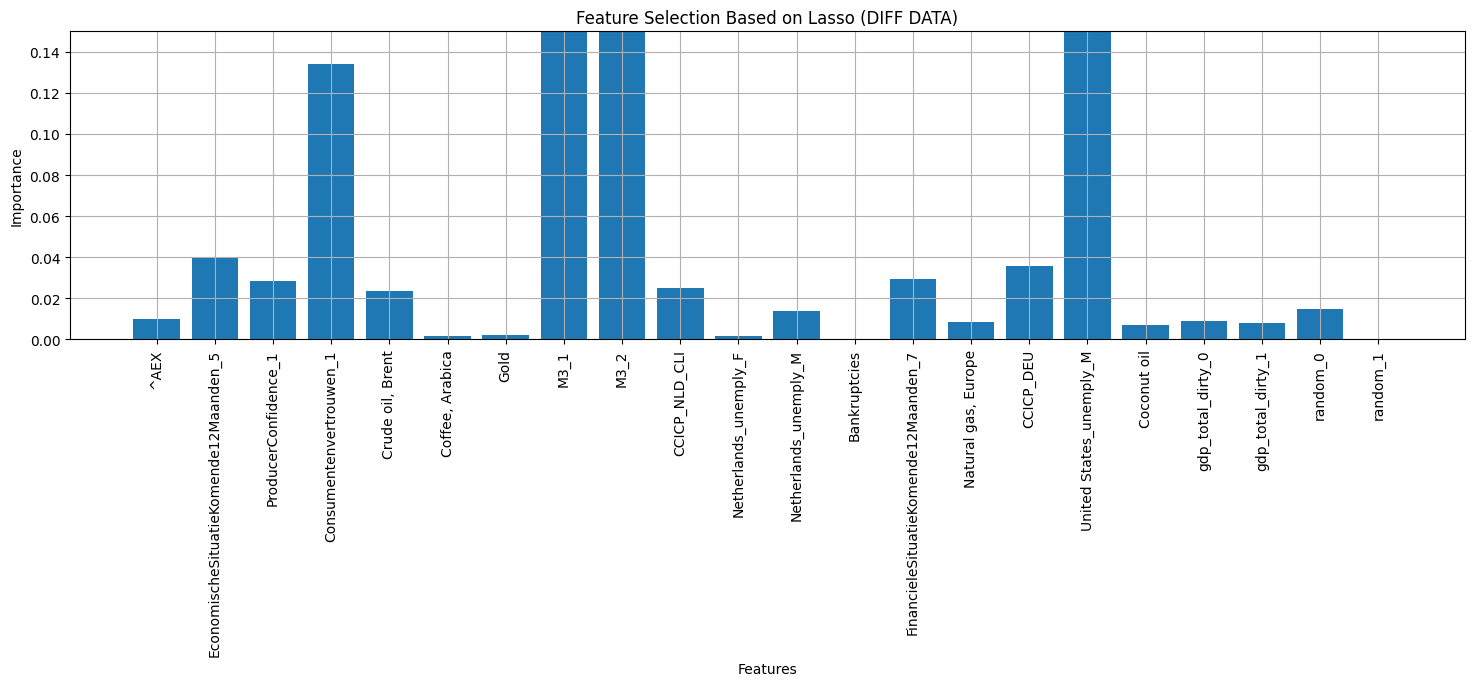

['^AEX',
 'EconomischeSituatieKomende12Maanden_5',
 'ProducerConfidence_1',
 'Consumentenvertrouwen_1',
 'Crude oil, Brent',
 'Coffee, Arabica',
 'Gold',
 'M3_1',
 'M3_2',
 'CCICP_NLD_CLI',
 'Netherlands_unemply_F',
 'Netherlands_unemply_M',
 'Bankruptcies',
 'FinancieleSituatieKomende12Maanden_7',
 'Natural gas, Europe',
 'CCICP_DEU',
 'United States_unemply_M',
 'Coconut oil',
 'gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_0',
 'random_1']

In [650]:
lassoreg(scaled_features_df.diff().dropna(), alpha=0.0, title='Feature Selection Based on Lasso (DIFF DATA)') 

In [651]:
df1 = scaled_features_df.copy()
number_lags = 1

df = df1.iloc[:,:]

for lag in range(1, number_lags+1):
    for col in df.columns:
        df[col + '_lag_' + str(lag)] = df[col].shift(lag)
    
selectThese = [col for col in df.columns if '_lag_' in col]
selectThese = ['gdp_total', 'gdp_total_dirty_0', 'gdp_total_dirty_1','random_0', 'random_1'] + selectThese 
df_lag = df[selectThese]

print(df_lag.shape)

(343, 28)


[ 0  1  4  5 12]
['gdp_total_dirty_0', 'gdp_total_dirty_1', 'gdp_total_lag_1', '^AEX_lag_1', 'M3_1_lag_1']


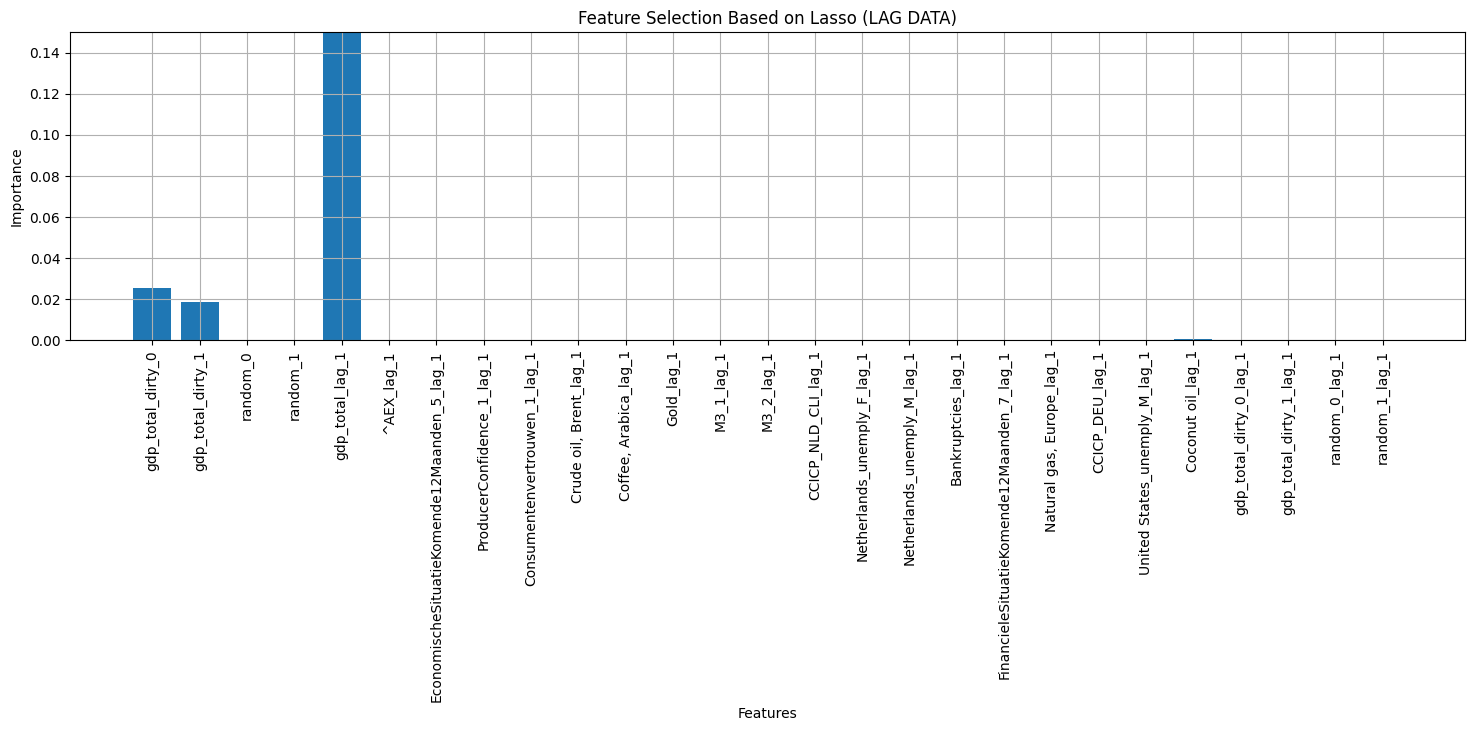

['gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'gdp_total_lag_1',
 '^AEX_lag_1',
 'M3_1_lag_1']

In [652]:
lassoreg(df_lag, alpha=0.01, title='Feature Selection Based on Lasso (LAG DATA)') 

[ 0  1  3  5  9 22 23 24 26]
['gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_1', '^AEX_lag_1', 'Crude oil, Brent_lag_1', 'Coconut oil_lag_1', 'gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1', 'random_1_lag_1']


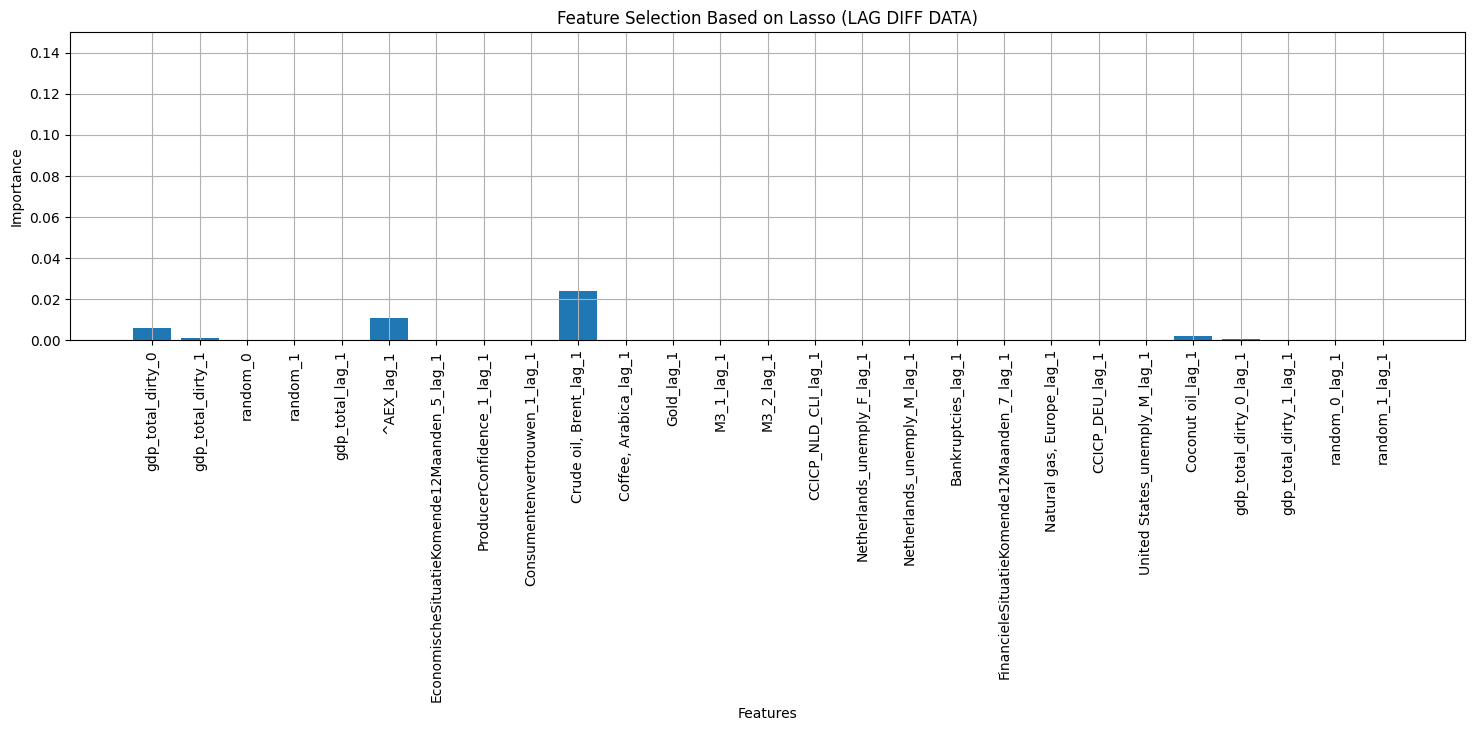

['gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_1',
 '^AEX_lag_1',
 'Crude oil, Brent_lag_1',
 'Coconut oil_lag_1',
 'gdp_total_dirty_0_lag_1',
 'gdp_total_dirty_1_lag_1',
 'random_1_lag_1']

In [653]:
lassoreg(df_lag.diff().dropna(), alpha=0.001, title='Feature Selection Based on Lasso (LAG DIFF DATA)') 


### Make sure data is stationary

In [654]:
def stationdarydf(mydata, STORE_FOR_TESTS, form='Levels', save=False):

    stationary_features = []
    seriesLength = []

    for col in mydata.columns:

        timeseries = mydata[col].dropna()
        seriesLength.append(len(timeseries))

        adf1 = adf_test(timeseries, verbose=False)
        kpss1 = kpss_test(timeseries, verbose=False)
        if adf1 == "Stationary" and kpss1 == "Stationary":
            stationary_features.append('Stationary')
            if form == 'Levels':
                STORE_FOR_TESTS.loc[col, 'Level_Stationary'] = 'Stationary'
            else:
                STORE_FOR_TESTS.loc[col, 'Difference_Stationary'] = 'Stationary'
        else:
            stationary_features.append('NotStationary')
            if form == 'Levels':
                STORE_FOR_TESTS.loc[col, 'Level_Stationary'] = 'NotStationary' 
            else:
                STORE_FOR_TESTS.loc[col, 'Difference_Stationary'] = 'NotStationary'
        
    df = pd.DataFrame(data = [mydata.columns, stationary_features, seriesLength]).T
    df.columns = ['Feature', 'Stationary', 'Length']    

    if save:
        df.to_csv(outputdata1 + "startionarity.csv")

    return df, STORE_FOR_TESTS

form = 'Levels'
df, STORE_FOR_TESTS = stationdarydf(scaled_features_df, STORE_FOR_TESTS, form, save=False)

print(df.shape)

(23, 3)


### If not stationary, difference, then test for stationarity again

In [655]:
def differenceData(originalData, STORE_FOR_TESTS, mydiff=1):

    ## which features are not stationary
    # function from above
    stat1, _ = stationdarydf(originalData, STORE_FOR_TESTS, form, save=False)
    # collect
    stat2 = stat1[stat1['Stationary'].str.contains('NotStationary')]
    notstationary = stat2['Feature'].tolist()

    # dont change orginal data
    stationarydf_diff = originalData.copy()

    # selectively difference the data
    for i in notstationary:
        stationarydf_diff[i] = stationarydf_diff[i].diff(mydiff)

    # rename columns
    for col in notstationary:
        STORE_FOR_TESTS.loc[col, "Difference_Data"] = "True"
    
    scaled_features_df_diff = stationarydf_diff.copy()

    return scaled_features_df_diff, STORE_FOR_TESTS

scaled_features_df_diff, STORE_FOR_TESTS = differenceData(scaled_features_df, STORE_FOR_TESTS, mydiff=1)

print(scaled_features_df_diff.shape)


(343, 23)


In [656]:
form = 'Differenced'
df1, STORE_FOR_TESTS = stationdarydf(scaled_features_df_diff, STORE_FOR_TESTS, form, save = 'False')
STORE_FOR_TESTS

,Qt_Seasonality,Semi_Seasonality,Level_Stationary,Difference_Stationary,Difference_Data,Monthly_Seasonality
gdp_total,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
^AEX,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
EconomischeSituatieKomende12Maanden_5,NaN,No_Semi_Seasonality,Stationary,Stationary,False,No_Monthly_Seasonality
ProducerConfidence_1,NaN,No_Semi_Seasonality,Stationary,Stationary,False,No_Monthly_Seasonality
Consumentenvertrouwen_1,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
"Crude oil, Brent",NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
"Coffee, Arabica",NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
Gold,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
M3_1,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality
M3_2,NaN,No_Semi_Seasonality,NotStationary,Stationary,True,No_Monthly_Seasonality


<Axes: >

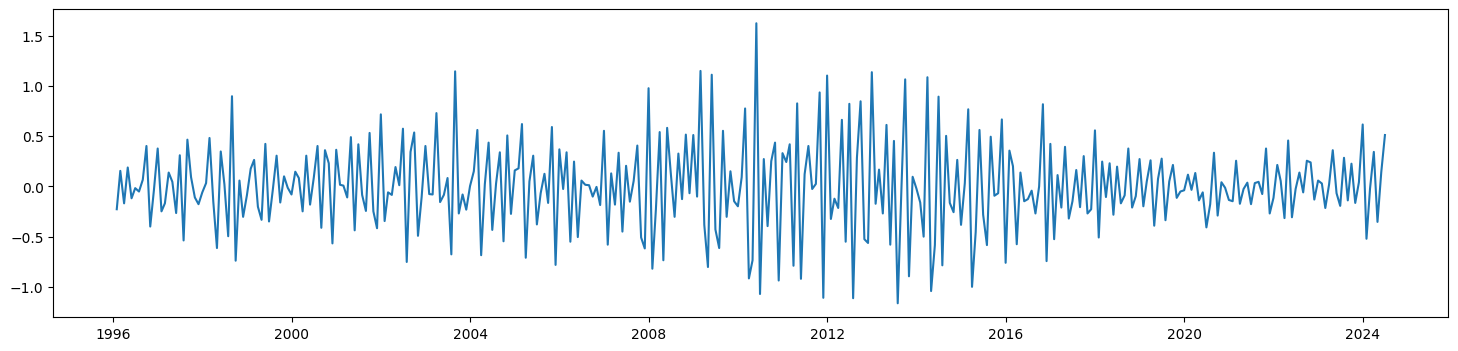

In [657]:
scaled_features_df_diff['Bankruptcies'].plot()

[ 0  1  2  3  4  7  9 11 12 13 14 15 16 17 18 19 20 21]
['^AEX', 'EconomischeSituatieKomende12Maanden_5', 'ProducerConfidence_1', 'Consumentenvertrouwen_1', 'Crude oil, Brent', 'M3_1', 'CCICP_NLD_CLI', 'Netherlands_unemply_M', 'Bankruptcies', 'FinancieleSituatieKomende12Maanden_7', 'Natural gas, Europe', 'CCICP_DEU', 'United States_unemply_M', 'Coconut oil', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_0', 'random_1']


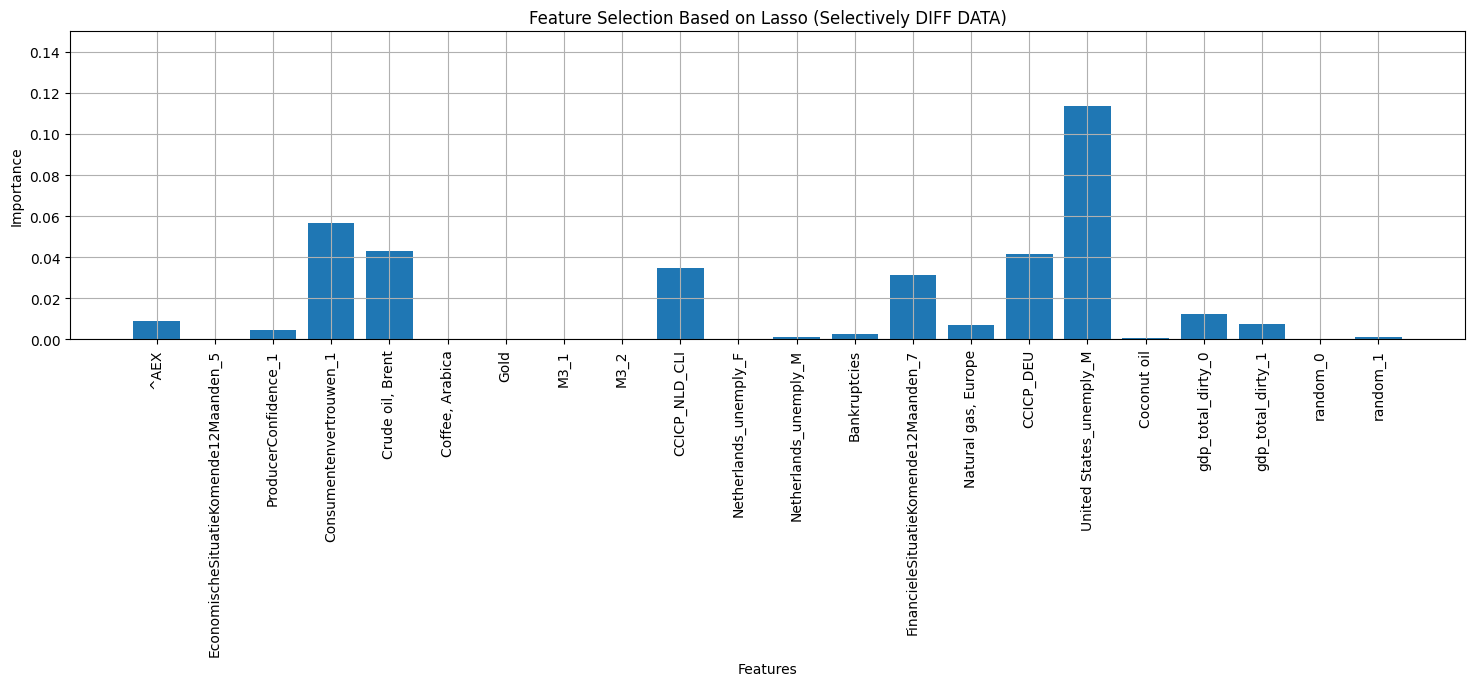

['^AEX',
 'EconomischeSituatieKomende12Maanden_5',
 'ProducerConfidence_1',
 'Consumentenvertrouwen_1',
 'Crude oil, Brent',
 'M3_1',
 'CCICP_NLD_CLI',
 'Netherlands_unemply_M',
 'Bankruptcies',
 'FinancieleSituatieKomende12Maanden_7',
 'Natural gas, Europe',
 'CCICP_DEU',
 'United States_unemply_M',
 'Coconut oil',
 'gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_0',
 'random_1']

In [658]:
lassoreg(scaled_features_df_diff.dropna(), alpha=0.0001, title='Feature Selection Based on Lasso (Selectively DIFF DATA)') 

(343, 23)


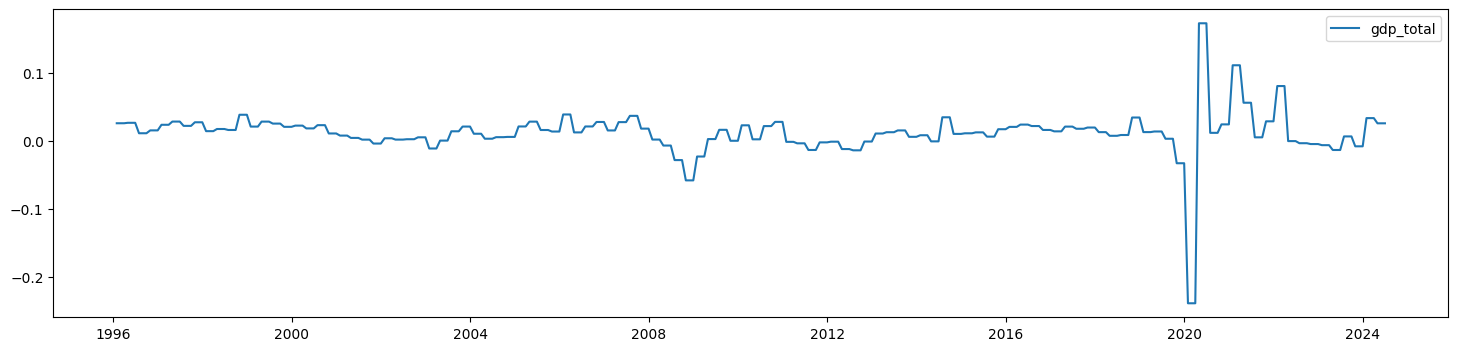

In [659]:
scaled_features_df_diff[['gdp_total']].plot()
scaled_features_df_diff.columns

print(scaled_features_df_diff.shape)

In [660]:
df = scaled_features_df_diff.copy()
number_lags = 1

for lag in range(1, number_lags+1):
    for col in df.columns:
        df[col + '_lag_' + str(lag)] = df[col].shift(lag)
    
selectThese = [col for col in df.columns if '_lag_' in col]
df_lag = df[selectThese]

scaled_features_df_diff_lag = scaled_features_df_diff.merge(df_lag, left_index=True, right_index=True)

print(scaled_features_df_diff_lag.shape)


(343, 46)


In [661]:
### Select if lagged 

chooseThese = ['gdp_total'] + [x for x in scaled_features_df_diff_lag.columns if '_lag' in x]
scaled_features_df_diff_lag_subset = scaled_features_df_diff_lag[chooseThese]

scaled_features_df_diff_lag_subset

,gdp_total,gdp_total_lag_1,^AEX_lag_1,EconomischeSituatieKomende12Maanden_5_lag_1,ProducerConfidence_1_lag_1,Consumentenvertrouwen_1_lag_1,"Crude oil, Brent_lag_1","Coffee, Arabica_lag_1",Gold_lag_1,M3_1_lag_1,...,Bankruptcies_lag_1,FinancieleSituatieKomende12Maanden_7_lag_1,"Natural gas, Europe_lag_1",CCICP_DEU_lag_1,United States_unemply_M_lag_1,Coconut oil_lag_1,gdp_total_dirty_0_lag_1,gdp_total_dirty_1_lag_1,random_0_lag_1,random_1_lag_1
1996-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-02-01,0.025842,NaN,NaN,0.493200,-0.022688,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.594828
1996-03-01,0.025842,0.025842,0.008161,0.062362,-0.256633,-0.222068,0.000932,0.243060,0.009004,0.005106,...,-0.226627,0.000000,0.002566,-0.165066,NaN,0.063549,-0.019007,-0.217228,NaN,-1.248289
1996-04-01,0.025842,0.025842,0.045542,-0.434759,-0.156371,-0.266482,0.062788,-0.058735,-0.014499,0.005289,...,0.155282,-0.150147,-0.012831,0.002334,NaN,-0.035305,0.575563,0.171761,NaN,1.066936
1996-05-01,0.026490,0.025842,0.069031,-0.699891,-0.156371,-0.088827,0.031705,0.048071,-0.005698,0.008231,...,-0.167872,0.150147,0.055173,0.002506,NaN,0.077671,0.088397,0.078514,NaN,1.162332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,0.033397,0.033397,0.353628,-0.898739,-0.490578,0.044414,0.109940,0.106339,-0.018314,0.000288,...,-0.520403,0.000000,-0.181075,0.158626,NaN,0.096524,-0.417059,-0.008277,NaN,-0.215773
2024-04-01,0.033397,0.033397,0.122973,-0.931881,-0.590840,0.222068,0.052313,0.001808,0.228537,0.057796,...,-0.020984,0.150147,0.052010,0.232923,NaN,0.273684,0.230327,0.468180,NaN,0.607387
2024-05-01,0.025749,0.033397,0.087919,-0.998164,-0.390316,0.044414,0.143199,0.549056,0.294112,-0.055815,...,0.344138,0.075074,0.068183,0.261002,NaN,0.323323,0.515832,-0.432292,NaN,-1.380013
2024-06-01,0.025749,0.025749,0.185764,-1.130729,-0.256633,-0.044414,-0.250498,-0.156796,0.033372,0.063003,...,-0.352531,-0.075074,0.133179,0.167010,NaN,-0.055288,-0.022090,0.237194,NaN,1.418043


In [662]:
### Remove 'sure' data

removeThese = ['gdp_total_dirty_0_lag_1', 'gdp_total_dirty_1_lag_1', 'random_0_lag_1', 'random_1_lag_1']
scaled_features_df_diff_lag_subset = scaled_features_df_diff_lag_subset.loc[:, ~scaled_features_df_diff_lag_subset.columns.isin(removeThese)]

print(scaled_features_df_diff_lag_subset.shape)

(343, 20)


[ 1  2  3  5 18]
['^AEX_lag_1', 'EconomischeSituatieKomende12Maanden_5_lag_1', 'ProducerConfidence_1_lag_1', 'Crude oil, Brent_lag_1', 'Coconut oil_lag_1']


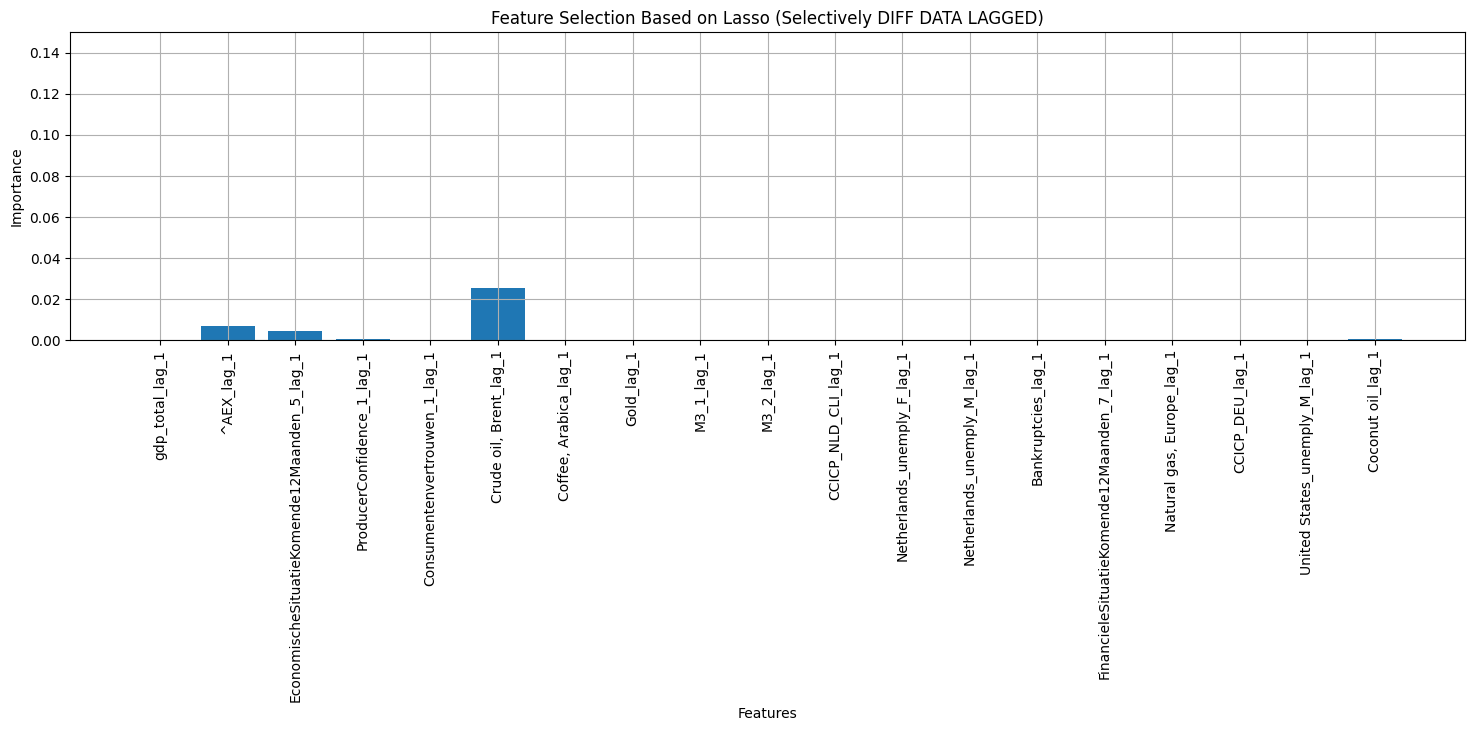

In [663]:
lasout = lassoreg(scaled_features_df_diff_lag_subset.dropna(), alpha=0.001, title='Feature Selection Based on Lasso (Selectively DIFF DATA LAGGED)') 

In [664]:
chooseThese = ['gdp_total'] + lasout 
print(chooseThese)

['gdp_total', '^AEX_lag_1', 'EconomischeSituatieKomende12Maanden_5_lag_1', 'ProducerConfidence_1_lag_1', 'Crude oil, Brent_lag_1', 'Coconut oil_lag_1']


In [665]:
scaled_features_df_diff_lag.shape

(343, 46)

In [666]:
reg1 = scaled_features_df_diff_lag[chooseThese]
reg1.to_csv("tmp.csv")
#reg1 = scaled_features_df_diff_lag[['random_0_lag_1', 'random_1_lag_1']]
reg1.dropna(inplace=True)

import statsmodels.api as sm

test_train_split = 280

X = reg1.iloc[0:test_train_split, 1:]
X = sm.add_constant(X)

y_true = reg1.iloc[0:test_train_split:, 0]

model = sm.OLS(y_true,X)
results = model.fit()
print(results.summary())


print(scaled_features_df_diff_lag.shape)
scaled_features_df_diff_lag

                            OLS Regression Results                            
Dep. Variable:              gdp_total   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     41.34
Date:                Wed, 04 Dec 2024   Prob (F-statistic):           1.25e-31
Time:                        15:40:31   Log-Likelihood:                 861.21
No. Observations:                 280   AIC:                            -1710.
Df Residuals:                     274   BIC:                            -1689.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

,gdp_total,^AEX,EconomischeSituatieKomende12Maanden_5,ProducerConfidence_1,Consumentenvertrouwen_1,"Crude oil, Brent","Coffee, Arabica",Gold,M3_1,M3_2,...,Bankruptcies_lag_1,FinancieleSituatieKomende12Maanden_7_lag_1,"Natural gas, Europe_lag_1",CCICP_DEU_lag_1,United States_unemply_M_lag_1,Coconut oil_lag_1,gdp_total_dirty_0_lag_1,gdp_total_dirty_1_lag_1,random_0_lag_1,random_1_lag_1
1996-01-01,NaN,NaN,0.493200,-0.022688,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-02-01,0.025842,0.008161,0.062362,-0.256633,-0.222068,0.000932,0.243060,0.009004,0.005106,0.005464,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.594828
1996-03-01,0.025842,0.045542,-0.434759,-0.156371,-0.266482,0.062788,-0.058735,-0.014499,0.005289,0.004972,...,-0.226627,0.000000,0.002566,-0.165066,NaN,0.063549,-0.019007,-0.217228,NaN,-1.248289
1996-04-01,0.025842,0.069031,-0.699891,-0.156371,-0.088827,0.031705,0.048071,-0.005698,0.008231,0.008839,...,0.155282,-0.150147,-0.012831,0.002334,NaN,-0.035305,0.575563,0.171761,NaN,1.066936
1996-05-01,0.026490,0.041676,-0.335335,-0.156371,0.177654,-0.058747,0.104344,-0.001560,0.016188,0.016717,...,-0.167872,0.150147,0.055173,0.002506,NaN,0.077671,0.088397,0.078514,NaN,1.162332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01,0.033397,0.122973,-0.931881,-0.590840,0.222068,0.052313,0.001808,0.228537,0.057796,0.061106,...,-0.520403,0.000000,-0.181075,0.158626,NaN,0.096524,-0.417059,-0.008277,NaN,-0.215773
2024-04-01,0.033397,0.087919,-0.998164,-0.390316,0.044414,0.143199,0.549056,0.294112,-0.055815,-0.060907,...,-0.020984,0.150147,0.052010,0.232923,NaN,0.273684,0.230327,0.468180,NaN,0.607387
2024-05-01,0.025749,0.185764,-1.130729,-0.256633,-0.044414,-0.250498,-0.156796,0.033372,0.063003,0.068046,...,0.344138,0.075074,0.068183,0.261002,NaN,0.323323,0.515832,-0.432292,NaN,-1.380013
2024-06-01,0.025749,0.103405,-1.031305,-0.189792,-0.044414,0.017406,0.322272,-0.041868,-0.024103,-0.027586,...,-0.352531,-0.075074,0.133179,0.167010,NaN,-0.055288,-0.022090,0.237194,NaN,1.418043


<Axes: >

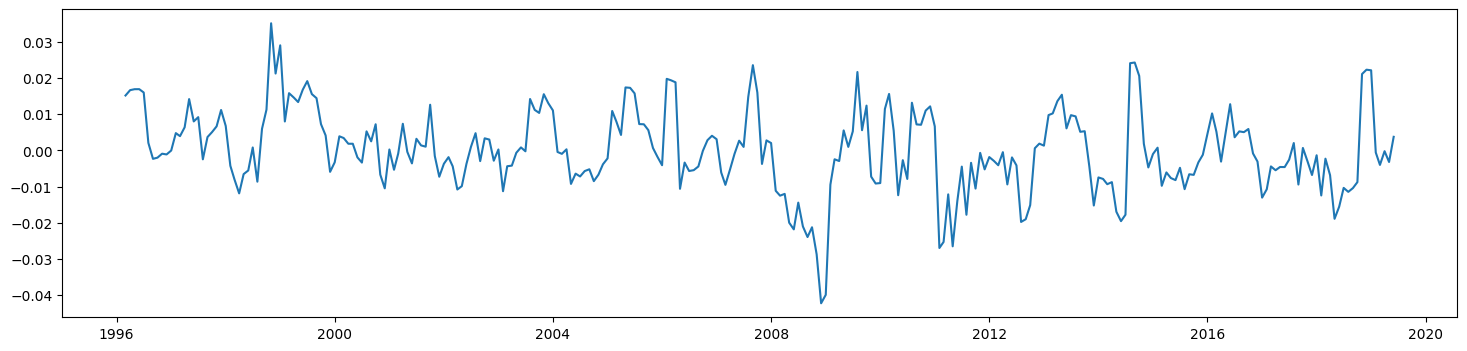

In [667]:
results.resid.plot()

In [668]:
ypred = results.predict(X)
Xnew = reg1.iloc[test_train_split:, 1:]
Xnew[['const']] = 1
reg1.iloc[test_train_split:, 0]

2019-07-01    0.013721
2019-08-01    0.003057
2019-09-01    0.003057
2019-10-01    0.003057
2019-11-01   -0.032960
                ...   
2024-03-01    0.033397
2024-04-01    0.033397
2024-05-01    0.025749
2024-06-01    0.025749
2024-07-01    0.025749
Name: gdp_total, Length: 61, dtype: float64

<Axes: >

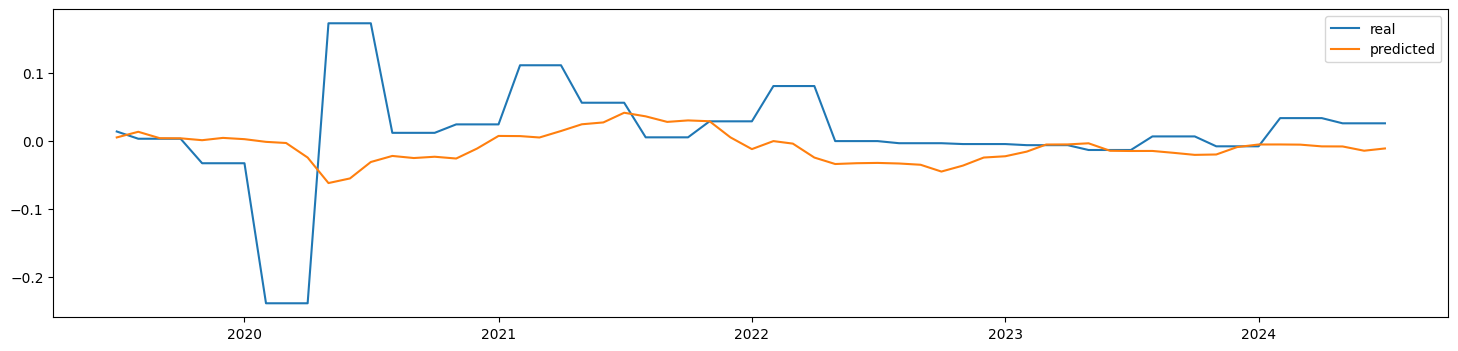

In [669]:

ynewpred = results.predict(Xnew)  # predict out of sample

# plot real and predicted values
pd.DataFrame({'real': reg1.iloc[test_train_split:, 0], 'predicted': ynewpred}).plot()

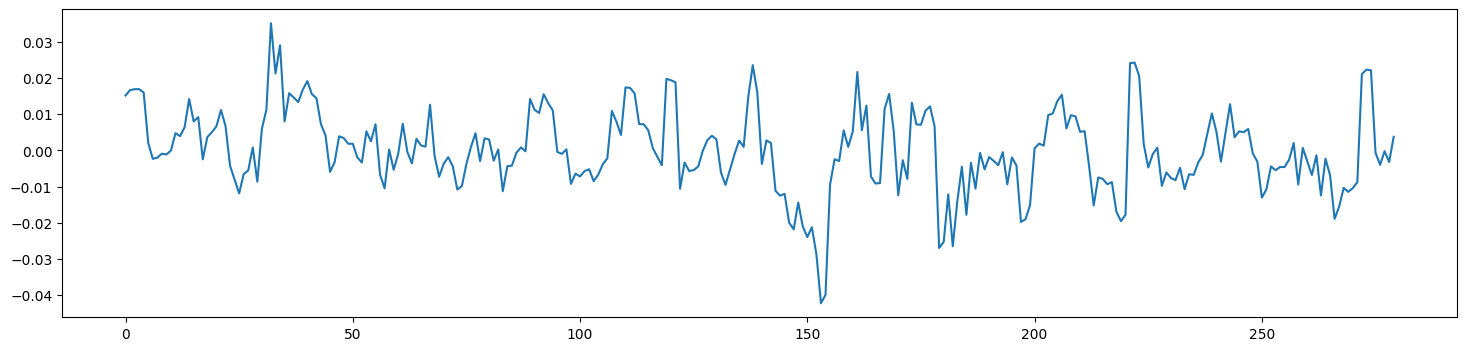

In [670]:
plt.plot(np.arange(0,(len(results.resid))), results.resid)

### Remove Covid for tests

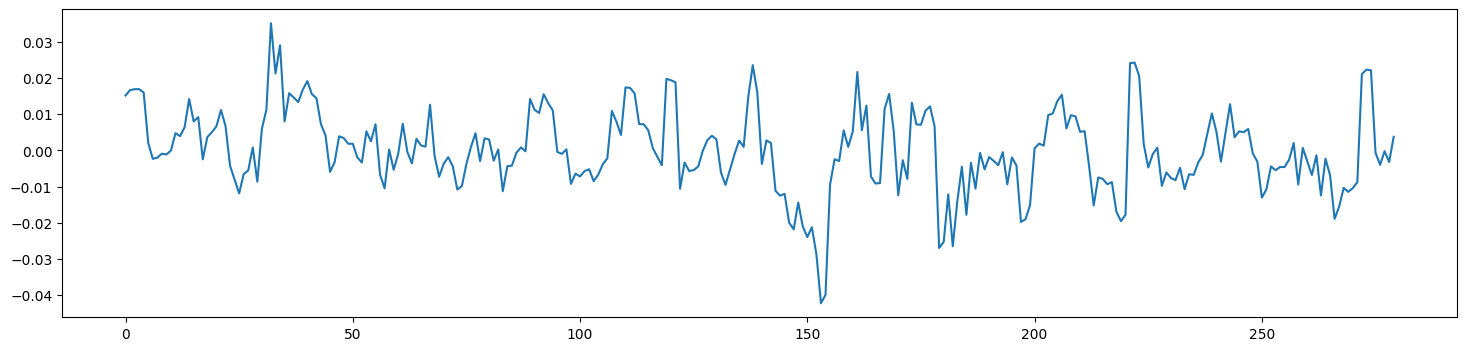

In [671]:
results.resid[results.resid < -0.20] = np.mean(results.resid)
results.resid[results.resid > 0.10] = np.mean(results.resid)
plt.plot(np.arange(0,(len(results.resid))), results.resid)

### Homoskedasticity

In [672]:
homoske = sm.stats.diagnostic.het_breuschpagan(results.resid, X)
if homoske[1] < 0.10:
    print('Heteroskedasticity (Breusch-Pagan)')
else:
    print('Homoskedasticity (Breusch-Pagan)')

Heteroskedasticity (Breusch-Pagan)


In [673]:
# Null hypothesis is homoscedastic and correctly specified.

homoske = sm.stats.diagnostic.het_white(results.resid, X)

if homoske[1] < 0.10:
    print('Heteroskedasticity (White)')
else:
    print('Homoskedasticity (White)')

Heteroskedasticity (White)


### Colinearity

In [674]:
def dw_test(resids):

    dw1 = sm.stats.stattools.durbin_watson(resids, axis=0)
    print(dw1)

    if dw1 > 2.0:
        if (4 - dw1) < 1.8: 
            print("Negative autoceorrelation is significant")
        else:
            print("Negative autocorrelation is not significant")
    else:
        if dw1 < 1.8:
            print("Positive autocorrelation is significant")
        else:
            print("Positive autocorrelation is not significant")

dw_test(results.resid)

0.5881979079387615
Positive autocorrelation is significant


### Normality

Residuals are normally distributed


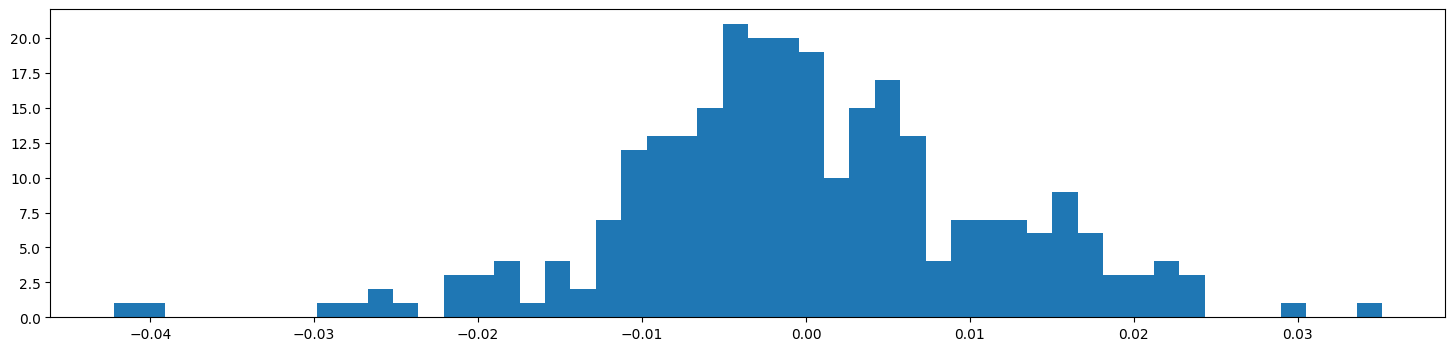

In [675]:
def normality_test(resids):

    _, p = sm.stats.diagnostic.kstest_normal(resids)

    if p < 0.05:
        print("Residuals are not normally distributed")
    else:
        print("Residuals are normally distributed")


normality_test(results.resid)

plt.hist(results.resid, bins=50);

[ 2  4  5  7  8 10 16 18 19]
['ProducerConfidence_1', 'Crude oil, Brent', 'Coffee, Arabica', 'M3_1', 'M3_2', 'Netherlands_unemply_F', 'United States_unemply_M', 'gdp_total_dirty_0', 'gdp_total_dirty_1']


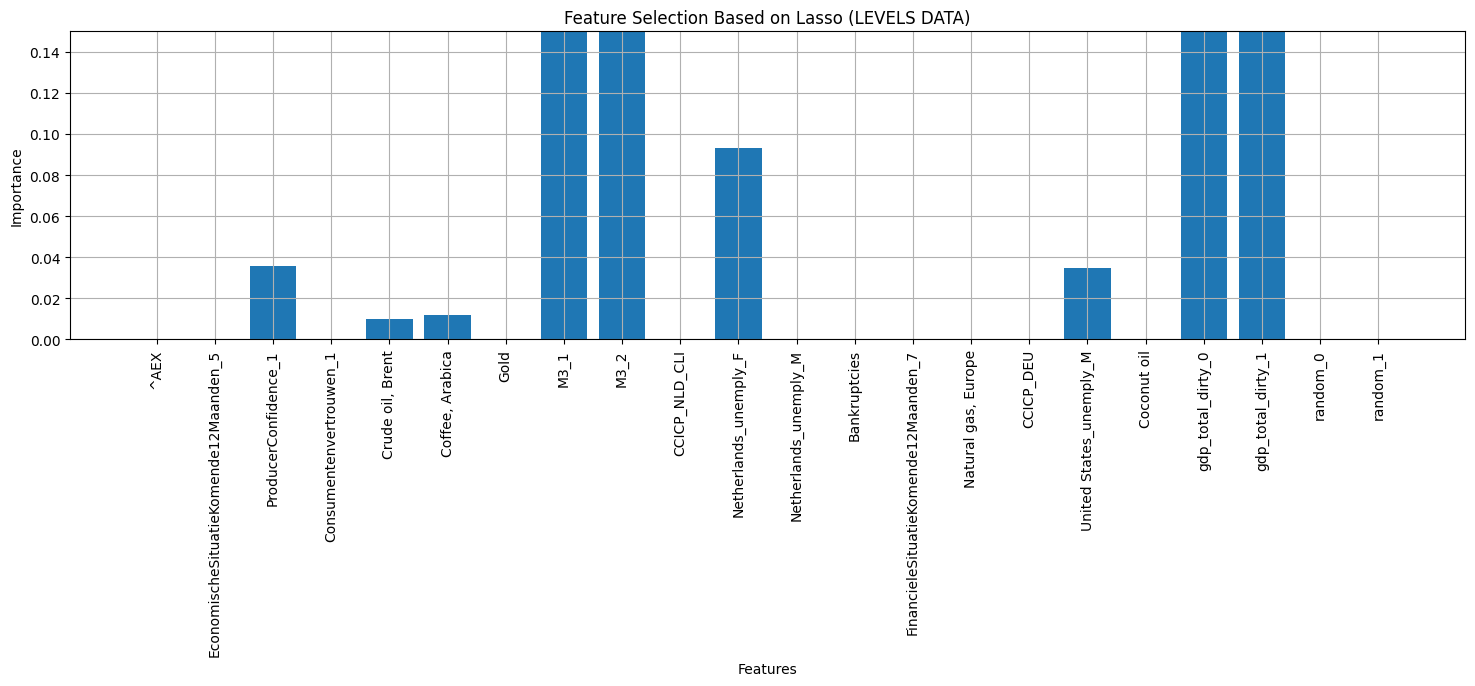

['ProducerConfidence_1',
 'Crude oil, Brent',
 'Coffee, Arabica',
 'M3_1',
 'M3_2',
 'Netherlands_unemply_F',
 'United States_unemply_M',
 'gdp_total_dirty_0',
 'gdp_total_dirty_1']

In [676]:
def lassoreg(data, alpha=0.0001, title='Feature Selection Based on Lasso'):

    myalpha = alpha
    data1 = data.copy()
    data1 = data1.dropna()

    Xcolnames =  data1.iloc[:, 1:]

    Y = data1.iloc[:, 0].values
    X = data1.iloc[:, 1:].values

    ### assertions
    # does X contain gdptotal, it should not
    assert X.shape[1] == data.shape[1] - 1

    # does X contain gdptotal, it should not
    val = 'gdp_total'
    lst = Xcolnames.columns
    assert val not in lst

    # regression
    lasso = Lasso(alpha = myalpha, fit_intercept=False, max_iter=10000)
    
    lasso.fit(X,Y)

    selected_features_lasso = np.flatnonzero(lasso.coef_)
    print(selected_features_lasso)

    best_variables = [Xcolnames.columns[i] for i in selected_features_lasso]
    print(best_variables)


    # calling the model with the best parameter
    lasso1 = Lasso(alpha=myalpha)
    lasso1.fit(X, Y)

    # Using np.abs() to make coefficients positive.  
    lasso1_coef = np.abs(lasso1.coef_)

    # plotting the Column Names and Importance of Columns. 
    plt.bar(lst, lasso1_coef)
    plt.xticks(rotation=90)
    plt.grid()
    plt.title(title)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.ylim(0, 0.15)
    plt.show()

    return best_variables


lassoreg(scaled_features_df, alpha=0.01, title='Feature Selection Based on Lasso (LEVELS DATA)')

[ 2  4 18 19 21]
['ProducerConfidence_1', 'Crude oil, Brent', 'gdp_total_dirty_0', 'gdp_total_dirty_1', 'random_1']


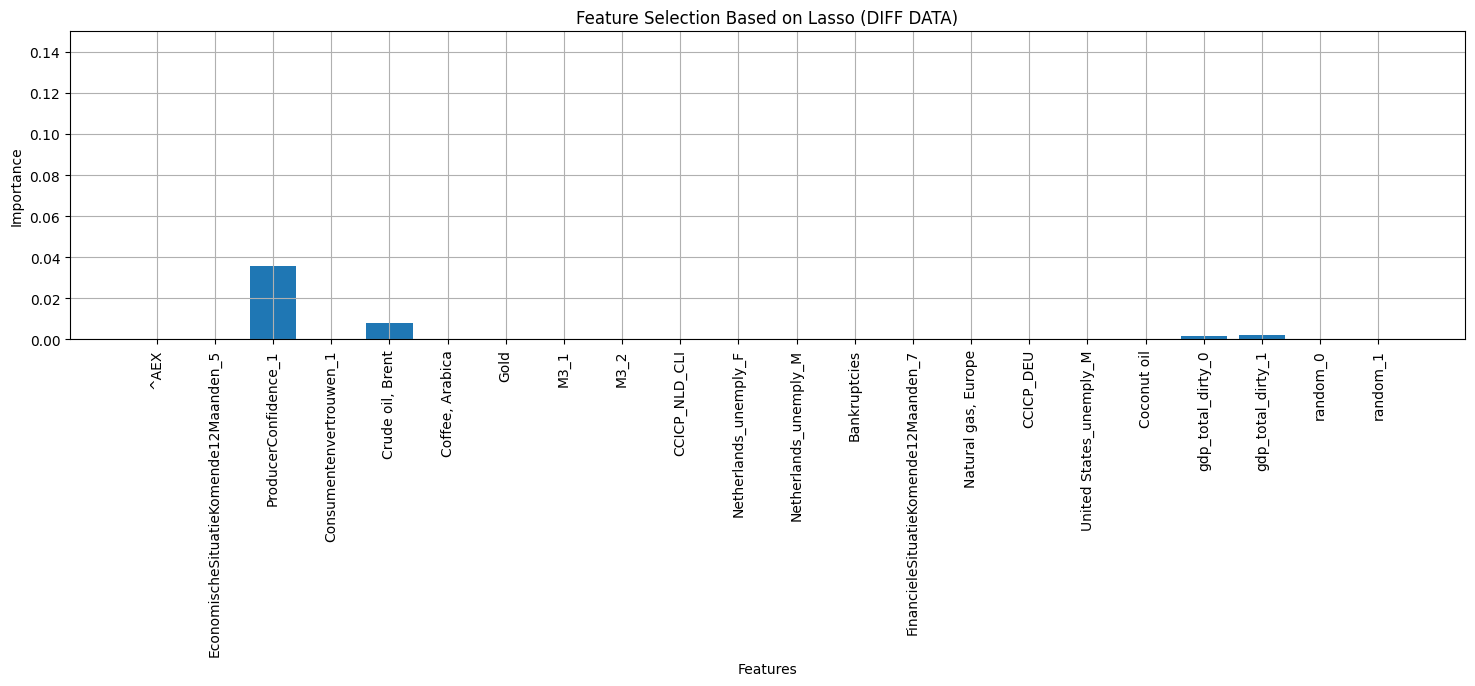

['ProducerConfidence_1',
 'Crude oil, Brent',
 'gdp_total_dirty_0',
 'gdp_total_dirty_1',
 'random_1']

In [677]:
lassoreg(scaled_features_df.diff().dropna(), alpha=0.001, title='Feature Selection Based on Lasso (DIFF DATA)') 

In [678]:
scaled_features_df.head()

,gdp_total,^AEX,EconomischeSituatieKomende12Maanden_5,ProducerConfidence_1,Consumentenvertrouwen_1,"Crude oil, Brent","Coffee, Arabica",Gold,M3_1,M3_2,...,Bankruptcies,FinancieleSituatieKomende12Maanden_7,"Natural gas, Europe",CCICP_DEU,United States_unemply_M,Coconut oil,gdp_total_dirty_0,gdp_total_dirty_1,random_0,random_1
1996-01-01,-2.134784,-1.513526,0.493200,-0.022688,0.594767,-1.254511,-0.673295,-0.984007,-1.579886,-1.619645,...,-0.281493,0.398418,-0.677436,-1.042324,NaN,-0.567503,-2.394721,-1.945914,NaN,-0.594828
1996-02-01,-2.108942,-1.505365,0.062362,-0.256633,0.372699,-1.253578,-0.430235,-0.975002,-1.574780,-1.614180,...,-0.508120,0.398418,-0.674870,-1.207390,NaN,-0.503954,-2.413728,-2.163142,NaN,-1.248289
1996-03-01,-2.083101,-1.459823,-0.434759,-0.156371,0.106217,-1.190791,-0.488970,-0.989501,-1.569491,-1.609208,...,-0.352839,0.248271,-0.687701,-1.205056,NaN,-0.539259,-1.838165,-1.991381,NaN,1.066936
1996-04-01,-2.057259,-1.390792,-0.699891,-0.156371,0.017390,-1.159086,-0.440900,-0.995199,-1.561260,-1.600370,...,-0.520711,0.398418,-0.632528,-1.202550,NaN,-0.461588,-1.749767,-1.912867,NaN,1.162332
1996-05-01,-2.030770,-1.349116,-0.335335,-0.156371,0.195044,-1.217833,-0.336555,-0.996759,-1.545071,-1.583653,...,-0.331855,0.548566,-0.669738,-1.228558,NaN,-0.409808,-2.041581,-2.155121,NaN,1.539281


In [679]:
df1 = scaled_features_df.copy()
number_lags = 1

df = df1.iloc[:,:]

for lag in range(1, number_lags+1):
    for col in df.columns:
        df[col + '_lag_' + str(lag)] = df[col].shift(lag)
    
selectThese = [col for col in df.columns if '_lag_' in col]
selectThese = ['gdp_total', 'gdp_total_dirty'] + selectThese 
df_lag = df[selectThese]

KeyError: "['gdp_total_dirty'] not in index"

In [ ]:
lassoreg(df_lag, alpha=0.01, title='Feature Selection Based on Lasso (LAG DATA)') 

In [ ]:
lassoreg(df_lag.diff().dropna(), alpha=0.001, title='Feature Selection Based on Lasso (LAG DIFF DATA)') 

### Make sure data is stationary

In [ ]:
scaled_features_df['ProducerConfidence_1'].plot()

In [ ]:
timeseries = scaled_features_df['ProducerConfidence_1']

In [ ]:

# adf test, if critical value is greater than test statistic, then the series is not stationary

def adf_test(timeseries, verbose=False):
    if verbose:
        print ('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    
    if verbose:
        print (dfoutput)
        print(dftest)

    if dftest[0] > dftest[4]['5%']:
        if verbose:
            print('ADF: Time Series is not Stationary')
       
        return "NotStationary"
    else:
        if verbose:    
            print('ADF: Time Series is Stationary') 
        return "Stationary" 


# adf_test(timeseries, verbose=True)   


In [ ]:

def kpss_test(timeseries, verbose=False):

    if verbose:
        print ('Results of KPSS Test:')

    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    
    if verbose:
        print (kpss_output)
        print(kpsstest[0])
        print(kpsstest[3])

    if kpsstest[0] > kpsstest[3]['5%']:
        if verbose:
            print('KPSS: Time Series is not Stationary')
        return "NotStationary"
    else: 
        if verbose:   
            print('KPSS: Time Series is Stationary')
        return "Stationary"

# kpss_test(timeseries, verbose=True) 

### Loop through KPSS and ADF tests, mark those series that need to be differenced

In [ ]:
def stationdarydf(mydata, save=False):

    stationary_features = []
    seriesLength = []

    for col in mydata.columns:

        timeseries = mydata[col].dropna()
        seriesLength.append(len(timeseries))

        adf1 = adf_test(timeseries, verbose=False)
        kpss1 = kpss_test(timeseries, verbose=False)
        if adf1 == "Stationary" and kpss1 == "Stationary":
            stationary_features.append('Stationary')
        else:
            stationary_features.append('NotStationary')
        
    df = pd.DataFrame(data = [mydata.columns, stationary_features, seriesLength]).T
    df.columns = ['Feature', 'Stationary', 'Length']    

    if save:
        df.to_csv(outputdata1 + "startionarity.csv")

    return df

#stationdarydf(scaled_features_df)

### If not stationary, difference, then test for stationarity again

replace in original data frame

In [ ]:

def differenceData(originalData, mydiff=1):
    
    ## which features are not stationary
    # function from above
    stat1 = stationdarydf(originalData)
    # collect
    stat2 = stat1[stat1['Stationary'].str.contains('NotStationary')]
    notstationary = stat2['Feature'].tolist()

    # dont change orginal data
    stationarydf_diff = originalData.copy()

    # selectively difference the data
    for i in notstationary:
        stationarydf_diff[i] = stationarydf_diff[i].diff(mydiff)

    # rename columns
    for col in notstationary:
        stationarydf_diff.rename(columns={col: col + "_diff"}, inplace=True)
    

    scaled_features_df_diff = stationarydf_diff.copy()

    return scaled_features_df_diff

scaled_features_df_diff = differenceData(scaled_features_df, mydiff=1)

In [ ]:
stationdarydf(scaled_features_df_diff, save = 'False')

In [ ]:
scaled_features_df_diff['Netherlands_unemply_F_diff'].plot()

In [ ]:
lassoreg(scaled_features_df_diff.dropna(), alpha=0.001, title='Feature Selection Based on Lasso (Selectively DIFF DATA)') 

In [ ]:
scaled_features_df_diff[['gdp_total_diff', 'Netherlands_unemply_F_diff']].plot()

In [ ]:

df_lag_diff = differenceData(df_lag, mydiff=1)
stationdarydf(df_lag_diff, save = 'False')

In [ ]:
df_lag_diff_diff = differenceData(df_lag_diff, mydiff=1)
stationdarydf(df_lag_diff_diff, save = 'False')

lassoreg(df_lag_diff_diff.dropna(), alpha=0.001, title='Feature Selection Based on Lasso (LAG Selectively DIFF DATA)') 

In [ ]:
df_lag_diff